In [2]:
from imports import *

In [8]:
num_extimators = 100
max_samples = 0.25
contamination = 0.2
eps = 0.2

ifsf = IsolationForest(max_samples=max_samples, random_state=0, contamination=contamination, n_estimators=num_extimators, n_jobs=-1)
lofsf = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=contamination, n_jobs=-1)
ocsvm = OneClassSVM(nu=contamination, kernel="rbf",gamma=0.1)
dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1)
estimators = {
    "if": ifsf,
    "lof": lofsf,
    "dbs": dbscan,
    "svm": ocsvm
}

In [10]:
# # sf = datasets.fetch_kddcup99(subset='SF', random_state=0, percent10=False)
# # dfsf = pd.DataFrame(sf.data, columns=sf_columns)
# df = pd.read_csv('kddcup.data', delimiter=',')
# df.columns = sa_columns + ["target"]
# print(set(df["flag"]))
# dfsf = df[(df["flag"]=='SF') & (df["logged_in"] == 1)]
# dfsf = dfsf[sf_columns+["target"]]
# anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]=='normal.'])/len(dfsf)
# print(f"SF anomaly rate is {anomaly_rate_sf:.1%}")

# dfsf['binary_target'] = [1 if x=='normal.' else -1 for x in dfsf["target"]]
# toDecodeSF = ["service", "target"]    
# leSF = preprocessing.LabelEncoder()
# for f in toDecodeSF:
#     dfsf[f] = leSF.fit_transform(dfsf[f])

# X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)
# results = []

In [11]:
sf = datasets.fetch_kddcup99(subset='SF',percent10 = False, random_state=0)
dfsf = pd.DataFrame(sf.data, columns=sf_columns)
dfsf["target"]=sf.target
anomaly_rate_sf = 1.0 - len(dfsf.loc[dfsf["target"]==b'normal.'])/len(dfsf)
print(f"SF anomaly rate is {anomaly_rate_sf:.1%}")

dfsf['binary_target'] = [1 if x==b'normal.' else -1 for x in dfsf["target"]]
toDecodeSF = ["service", "target"]    
leSF = preprocessing.LabelEncoder()
for f in toDecodeSF:
    dfsf[f] = list(map(byte_decoder, dfsf[f]))
    dfsf[f] = leSF.fit_transform(dfsf[f])

X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfsf.drop(["target", 'binary_target'], axis=1), dfsf['binary_target'], test_size=0.33, random_state=0)

MemoryError: 

trainning finished in 0:00:24.606742
              precision    recall  f1-score   support

     anomaly       0.02      1.00      0.04      1043
      normal       1.00      0.80      0.89    230504

    accuracy                           0.80    231547
   macro avg       0.51      0.90      0.47    231547
weighted avg       1.00      0.80      0.89    231547

AUC:  90.0%


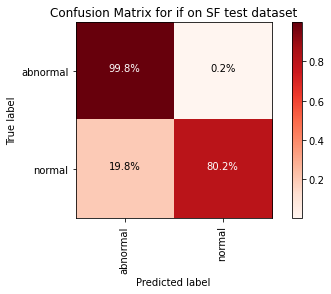

In [14]:
results.append(model("if", "SF"))

trainning finished in 0:00:08.336945
              precision    recall  f1-score   support

     anomaly       0.00      0.09      0.00      1043
      normal       0.99      0.80      0.89    230504

    accuracy                           0.80    231547
   macro avg       0.50      0.45      0.45    231547
weighted avg       0.99      0.80      0.88    231547

AUC:  44.7%


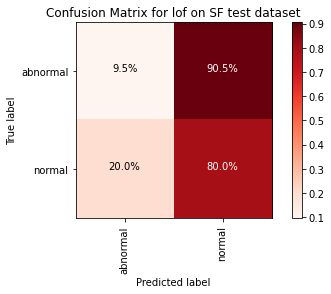

In [5]:
results.append(model("lof", "SF"))

In [5]:
results.append(model("dbscan", "SF"))

KeyError: 'dbscan'

In [ ]:
results.append(model("svm", "SF"))

In [ ]:
results